In [1]:
import math
from pathlib import Path

import glob2
import torch
from scipy import signal
import datetime
import os.path

import numpy as np
from scipy.signal import find_peaks, peak_widths
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
import pickle
import tensorflow as tf
from line_profiler_pycharm import profile

from utils.data_reading.sound_data.station import StationsCatalog
from utils.training.TiSSNet import TiSSNet_torch as TiSSNet
from utils.training.embedder import Embedder, EmbedderSegmenter
from utils.transformations.features_extractor import STFTFeaturesExtractor

2024-10-04 18:40:02.075489: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 18:40:02.179091: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 18:40:02.656152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 18:40:02.656360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 18:40:02.731235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
datasets_yaml = "/home/plerolland/Bureau/dataset.yaml"
tissnet_checkpoint = "../../data/model_saves/TiSSNet/torch_save"
embedder_checkpoint = "../../data/model_saves/embedder/torch_save_segmenter"

# output files
DELTA = datetime.timedelta(seconds=3600/0.98)  # /0.98 to get 1h segments
TIME_RES = 500 / 936  # duration of each spectrogram pixel in seconds
FREQ_RES = 240 / 256  # f of each spectrogram pixel in Hz
TIME_RES_embedder = 0.5
FREQ_RES_embedder = 0.5
MAX_F = 120  # max tolerated f, which means we discard some pixel lines in case of IMS
REQ_WIDTH = int(DELTA.total_seconds() / TIME_RES)
REQ_WIDTH_embedder = int(DELTA.total_seconds() / TIME_RES_embedder)

OVERLAP = 0.02  # overlap for models application (no link with STFT)
STEP = (1 - OVERLAP) * DELTA

TISSNET_PROMINENCE = 0.05
ALLOWED_ERROR_S = 5
MIN_HEIGHT = 0.05

batch_size = 16

In [3]:
stations_c = StationsCatalog(datasets_yaml).filter_out_undated().filter_out_unlocated()
stft_computer = STFTFeaturesExtractor(None, vmin=-35, vmax=140)
stft_computer_embedder = STFTFeaturesExtractor(None, vmin=60, vmax=140)

#model = TiSSNet()
#model.load_weights(tissnet_checkpoint)
device = "cuda"
model_det = torch.load(tissnet_checkpoint).to(device)
model_embedder = torch.load(embedder_checkpoint).to(device)
model_det.eval()
model_embedder.eval()

EmbedderSegmenter(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 7), stride=(1, 1), padding=same)
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 7), stride=(1, 1), padding=same)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (14): 

In [ ]:
def process_batch(batch):
    try:
        batch = np.array(batch)
    except:
        print("not rectangular array")
    batch = torch.from_numpy(batch).to(device)
    with torch.no_grad():
        res = model_det(batch).cpu().numpy()
    del batch
    torch.cuda.empty_cache()
    return res

def embed_batch(batch):
    try:
        batch = np.array(batch)
    except:
        print("not rectangular array")
    batch = torch.from_numpy(batch).to(device)
    with torch.no_grad():
        res = model_embedder(batch).cpu().numpy()
    del batch
    torch.cuda.empty_cache()
    return res

for year in [2012, 2018, 2017, 2016, 2015, 2014, 2013, 2011, 2010]:
    Path(f"../../data/detections/{year}/").mkdir(parents=True, exist_ok=True)
    print(f"Starting detection on year {year}")
    stations = stations_c.ends_after(datetime.datetime(year,1,1) - datetime.timedelta(days=1))
    stations = stations.starts_before(datetime.datetime(year+1,1,1) + datetime.timedelta(days=1))
    for station in stations:
        embedding_path = f"../../data/detections/{year}/embedding_{year}_{station.name}-{station.date_start.year}"
        Path(embedding_path).mkdir(parents=True, exist_ok=True)
        results_file = f"../../data/detections/{year}/log_det_{year}_{station.name}-{station.date_start.year}.p"

        print(f"Processing station {station.name}-{station.date_start.year}")
        stft_computer.manager = station.get_manager()
        stft_computer.nperseg = round(stft_computer.manager.sampling_f / FREQ_RES)
        stft_computer.overlap = 1 - TIME_RES * stft_computer.manager.sampling_f / stft_computer.nperseg
        stft_computer_embedder.manager = station.get_manager()
        stft_computer_embedder.nperseg = int(stft_computer.manager.sampling_f / FREQ_RES_embedder)
        stft_computer_embedder.overlap = 1 - TIME_RES_embedder * stft_computer.manager.sampling_f / stft_computer.nperseg
        max_f_cut_line = round(MAX_F / FREQ_RES)
        max_f_cut_line_embedder = round(MAX_F / FREQ_RES_embedder)
        
        start = max(datetime.datetime(year,1,1), station.date_start + datetime.timedelta(days=1))
        end = min(datetime.datetime(year+1,1,1), station.date_end - datetime.timedelta(days=1))
        steps = math.ceil((end-start)/STEP)
        start_idx = 0
        batch_dates, batch_process, batch_process_embedder = [], [], []
        
        existing_embedding_paths = glob2.glob(f"{embedding_path}/*.npy")
        if len(existing_embedding_paths)>0:
            last_date = np.max([datetime.datetime.strptime(p.split("/")[-1][:-4], "%Y%m%d_%H%M%S") for p in existing_embedding_paths])
            del existing_embedding_paths
            print(f'Station {station.name} already processed up to {last_date.strftime("%Y%m%d_%H%M%S")}')
            start_idx = math.floor((last_date - start) / STEP)

        for i in tqdm(range(steps), smoothing=0.001):
            if i < start_idx:
                continue # this is just to fill a part of tqdm
                
            seg_start = start + i * STEP
            seg_end = min(end, seg_start + DELTA)
            if seg_start >= seg_end:
                break
            
            data_raw = station.get_manager().getSegment(seg_start, seg_end)
            data = stft_computer._get_features(data_raw)[-1][:max_f_cut_line].astype(np.uint8)
            data = (data[np.newaxis, :, :] / 255).astype(np.float32)
            data_reduce = stft_computer_embedder._get_features(data_raw)[-1][:max_f_cut_line_embedder]
            data_reduce = 2*(data_reduce[np.newaxis, :, :] / 255 - 0.5).astype(np.float32)
            del data_raw  # reclaim some RAM
            if REQ_WIDTH*1.02 > data.shape[-1] > REQ_WIDTH*0.98: # we resize it to a standard number of time steps
                data = Resize((128, REQ_WIDTH))(torch.from_numpy(data)).numpy()
                data_reduce = Resize((64, REQ_WIDTH_embedder))(torch.from_numpy(data_reduce)).numpy()
            batch_dates.append(seg_start)
            batch_process.append(data)
            batch_process_embedder.append(data_reduce)

            if len(batch_process) == batch_size:
                if batch_process[-1].shape != batch_process[0].shape or batch_process[-2].shape != batch_process[-1].shape:
                    # last (and probably the one before because of overlaps) batch has a last element shorter than the others, we make three batches
                    rlastlast = process_batch(batch_process[-2])
                    rlast = process_batch(batch_process[-1])
                    rfirst = process_batch(batch_process[:-2])
                    res = list(rfirst) + [rlastlast] + [rlast]
                    del batch_process # reclaim some RAM
                    
                    rlastlast_embedder = embed_batch(batch_process_embedder[-2])
                    rlast_embedder = embed_batch(batch_process_embedder[-1])
                    rfirst_embedder = embed_batch(batch_process_embedder[:-2])
                    res_embedder = list(rfirst_embedder) + [rlastlast_embedder] + [rlast_embedder]
                    del batch_process_embedder # reclaim some RAM
                else:
                    res = process_batch(batch_process)
                    del batch_process # reclaim some RAM
                    res_embedder = embed_batch(batch_process_embedder)
                    del batch_process_embedder # reclaim some RAM


                for i, (seg_start, r) in enumerate(zip(batch_dates, res)):
                    res_embedder_ = res_embedder[i].astype(np.float16)
                    res_embedder_ = res_embedder_[:, int(res_embedder_.shape[1]*OVERLAP/2):-int(res_embedder_.shape[1]*OVERLAP/2)]
                    np.save(f'{embedding_path}/{(seg_start+DELTA*OVERLAP/2).strftime("%Y%m%d_%H%M%S")}.npy', res_embedder_)
                    peaks = find_peaks(r, height=0, distance=ALLOWED_ERROR_S / TIME_RES, prominence=TISSNET_PROMINENCE)
                    time_s = peaks[0] * TIME_RES
                    peaks = [(seg_start + datetime.timedelta(seconds=time_s[j]), peaks[1]["peak_heights"][j]) for j in range(len(time_s)) if peaks[1]["peak_heights"][j] > MIN_HEIGHT and peaks[0][j] > REQ_WIDTH*OVERLAP/2 and peaks[0][j] < REQ_WIDTH*(1-OVERLAP/2)]
                        
                    with open(results_file, "ab") as f:
                        for i, (d, p) in enumerate(peaks):
                            pickle.dump([d, p.astype(np.float16)], f)
                
                batch_dates, batch_process, batch_process_embedder = [], [], []
                
# Run time of PyTorch TiSSNet on IMS : ~2h per y or ~20s per d or ~0.82s per h

Starting detection on year 2012
Processing station MAD-2012
Station MAD already processed up to 20121231_081038


  0%|          | 0/7103 [00:00<?, ?it/s]

/home/plerolland/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Processing station NCRO3-2012
Station NCRO3 already processed up to 20120910_003254


  0%|          | 0/8071 [00:00<?, ?it/s]

In [24]:
s, y, yt = "ELAN", 2018, 2018

to_read = f"../../data/detections/{y}/log_det_{yt}_{s}-{y}.csv"
with open(to_read, "r") as f:
    lines = f.readlines()
lines = [line.strip().split(",") for line in lines if len(line.strip())>0]
lines = np.array([[datetime.datetime.strptime(line[0], "%Y%m%d_%H%M%S"), float(line[1]), line[2]] for line in lines])
lines = lines[lines[:,1] > 0.5]
lines[:,2] = [np.array(l.split(";")).astype(np.float32) for l in lines[:,2]]
np.random.shuffle(lines)

In [33]:
np.random.shuffle(lines)

[[0.         0.2532672  0.27759937 0.26621591 0.20392468 0.30730717
  0.41110116 0.24983368]
 [0.2532672  0.         0.28839013 0.2981345  0.32558027 0.20062581
  0.42000683 0.27962162]
 [0.27759937 0.28839013 0.         0.20304575 0.25458983 0.19114822
  0.30226021 0.39140438]
 [0.26621591 0.2981345  0.20304575 0.         0.32654554 0.20974299
  0.38104296 0.41914775]
 [0.20392468 0.32558027 0.25458983 0.32654554 0.         0.32706907
  0.36690201 0.24377137]
 [0.30730717 0.20062581 0.19114822 0.20974299 0.32706907 0.
  0.31546499 0.36740689]
 [0.41110116 0.42000683 0.30226021 0.38104296 0.36690201 0.31546499
  0.         0.42983565]
 [0.24983368 0.27962162 0.39140438 0.41914775 0.24377137 0.36740689
  0.42983565 0.        ]]


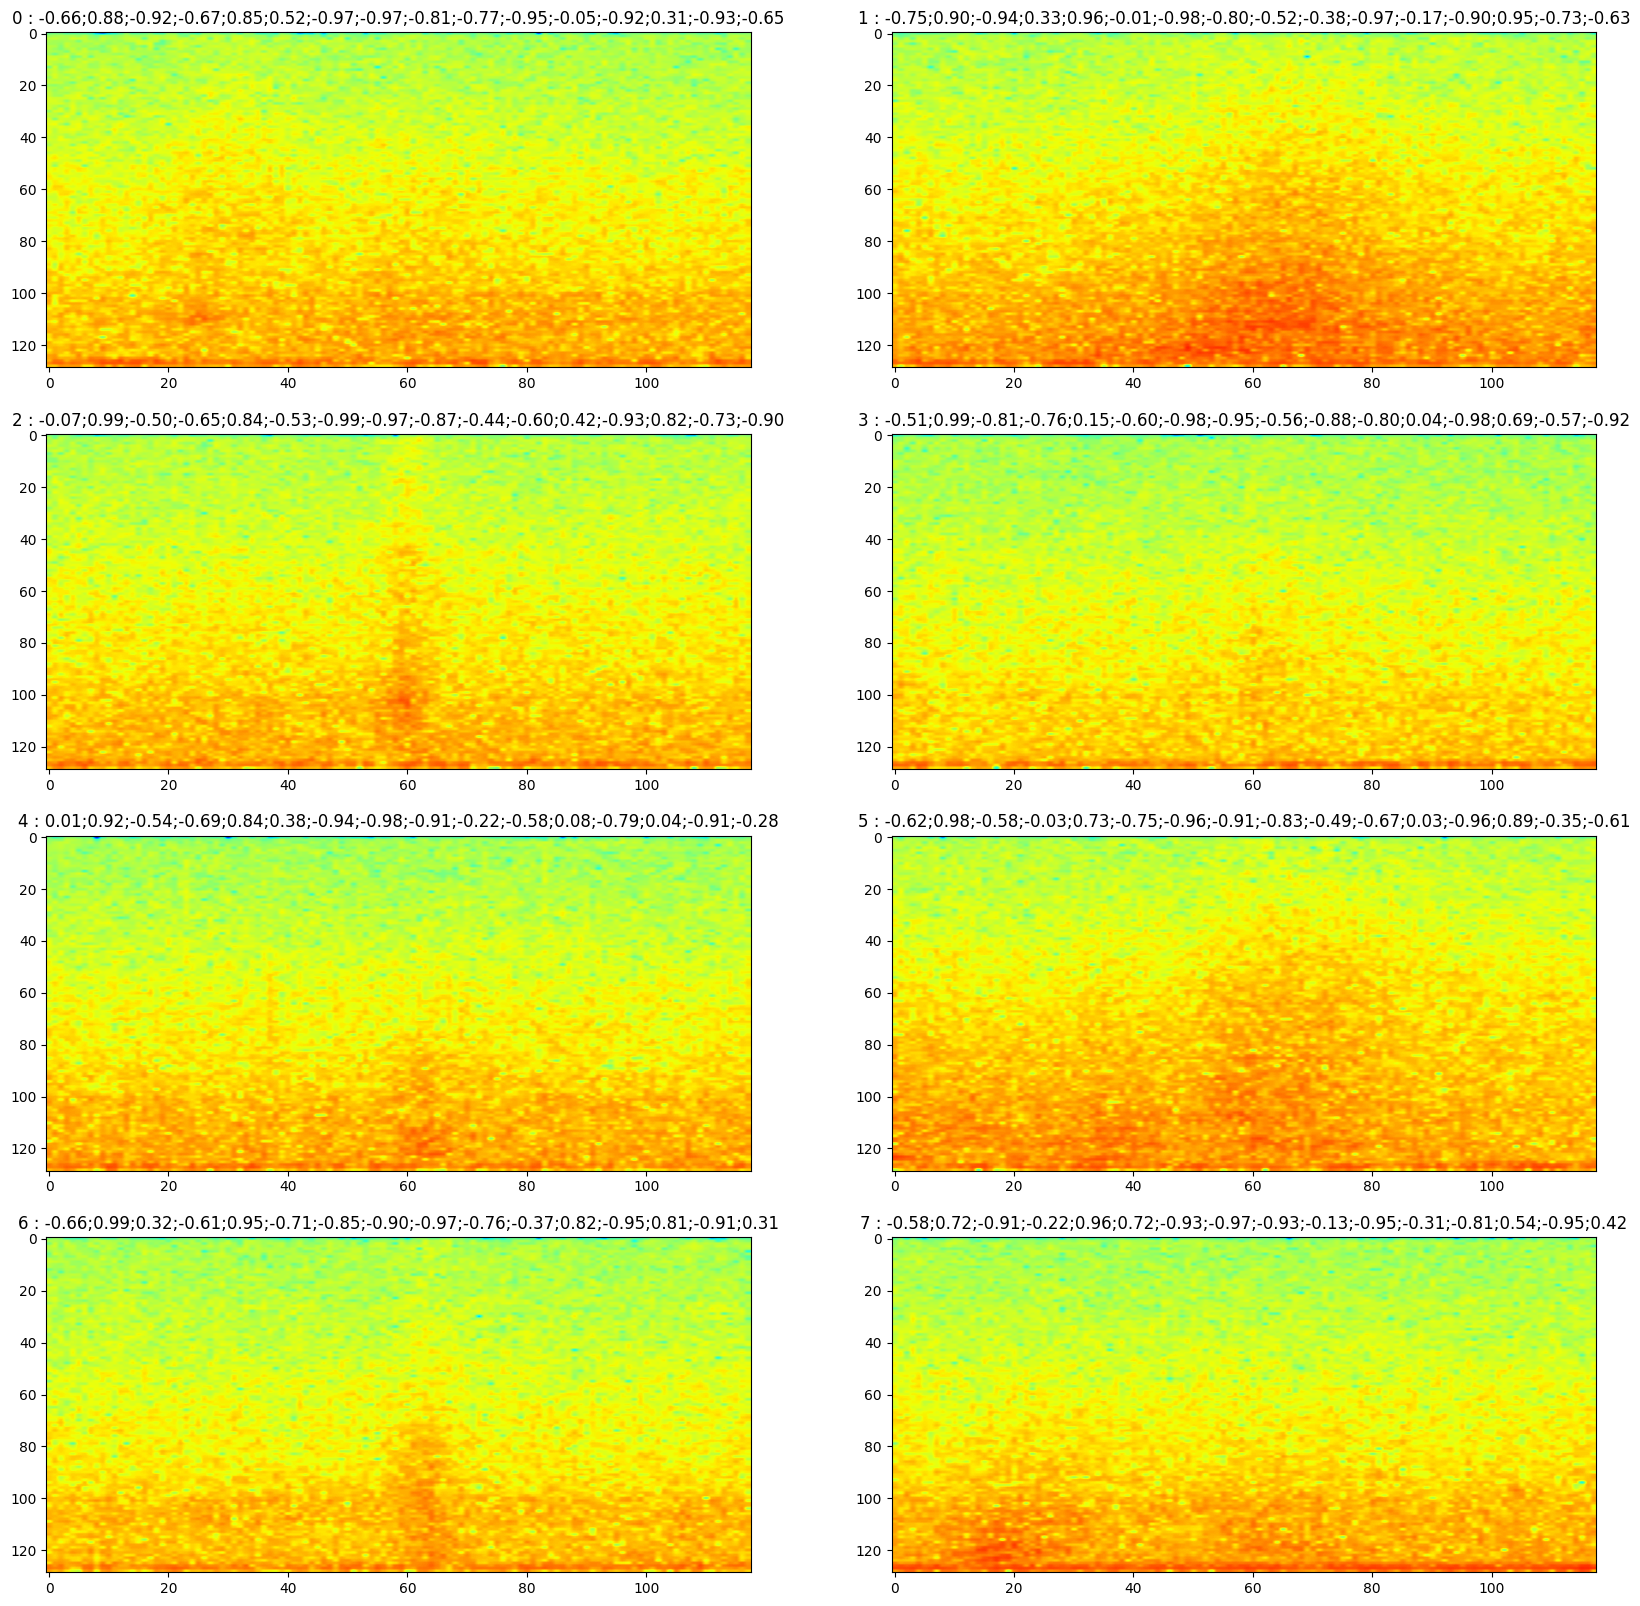

In [34]:
from matplotlib import pyplot as plt

station = stations_c.by_names(s).by_starting_year(y)[0]
stft_computer.manager = station.get_manager()
delta = datetime.timedelta(seconds=32)


dist = np.zeros((8,8))
fig, axs = plt.subplots(4, 2, figsize=(20,20))
for i in range(4):
    for j in range(2):
        d, p, e = tuple(lines[i*2+j])
        data = stft_computer.get_features(d-delta, d+delta)[-1].astype(np.uint8)
        axs[i,j].imshow(data, cmap="jet", vmin=0, vmax=255, aspect="auto")
        axs[i,j].set_title(str(i*2+j) + " : " + ";".join([f"{v:.2f}" for v in e]))
        axs[i,j].grid(False)
        
        for l in range(8):
            _, _, e2 = tuple(lines[l])
            dist[i*2+j,l] = np.sqrt(np.sum(np.square(e-e2)))/np.sqrt(16*2)
print(dist)